# Applying Machine Learning Models

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [3]:
train = pd.read_csv('UCI_HAR_Dataset/csv_files/train.csv')
test = pd.read_csv('UCI_HAR_Dataset/csv_files/test.csv')
print(train.shape, test.shape)

(7352, 564) (2947, 564)


In [4]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


## Making Data for Model

In [5]:
# 訓練用
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train['ActivityName']

# テスト用
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test["ActivityName"]

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


Labels that are usuful in plotting confusion matrix

In [6]:
labels = ['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

Let's make a function to plot the confusion matrix

In [7]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [8]:
# 任意のモデルを実行
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(6, 6))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    
    return results
    

Make function to print the gridsearch Parameters

In [9]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

## 1. Logistic Regression with Grid Search

[グリッドサーチ参考サイト](https://data-analysis-stats.jp/機械学習/grid-search-のパラメタチューニング/)

training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:03:27.608852

Predicting test data
==> testing time:- 0:00:00.328380

==> Accuracy:- 0.9589412962334578


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 432  56   0   0   3]
 [  0  16 516   0   0   0]
 [  0   0   0 493   2   1]
 [  0   0   0   4 403  13]
 [  0   0   0  25   1 445]]


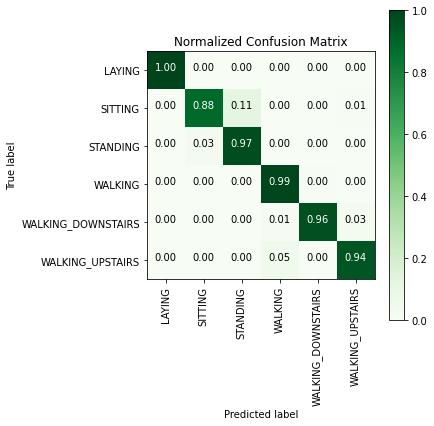

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.98       420
  WALKING_UPSTAIRS       0.96      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



==> Best Estimator:
	LogisticRegression(C=1, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of vest estimator : 0.933495007792376


In [52]:
'''
GridSearchCVのパラメータ

estimator : estimator object
チューニングを行うモデル

param_grid : dict or list of dictionaries
パラメタ候補値を「パラメタ名, 候補値リスト」の辞書で与える

scoring : string, callable, list/tuple, dict or None, default: None
複数のメトリックを評価するには、文字例のリストか、の辞書で与える

n_jobs : int or None, optional (default=None)
同時実行数(-1にするとコア数で同時実行)

pre_dispatch : int, or string, optional
同時実行数にディスパッチされるジョブの数を設定する

iid : boolean, default=’warn’
Trueの場合、各テストセットのサンプル数で重み付けされた、折り畳み全体の平均スコアを返す

cv : int, cross-validation generator or an iterable, optional
Cross validationの分割数(デフォルト値は3)

refit : boolean, string, or callable, default=True
Trueだと最良だったパラメタを使い学習データ全体で再学習する

verbose : integer
ログ出力レベル（高ければ高いほど、長い出力）

error_score : ‘raise’ or numeric
エラーが発生した場合にスコアに割り当てる値。

return_train_score : boolean, default=False
Falseの場合は、トレーニングスコアを含まない
'''


import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# start Grid search
# C: 正則化項の係数（正則化の強さの逆数）
# penalty: 正則化をL1ノルムでやるかL2ノルムでやるかを，l1 または l2 から選択
param_grid = [{
    'C': [0.01, 0.1, 1, 10, 20, 30],
    'penalty': ['l2', 'l1']
}]


log_reg = linear_model.LogisticRegression(random_state=0)
log_reg_grid = GridSearchCV(log_reg, param_grid=param_grid, cv=5, verbose=1, n_jobs=1)
log_reg_grid_results = perform_model(log_reg_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels)

# observe the attributes of the model
print_grid_search_attributes(log_reg_grid_results['model'])

## 1. Logistic Regression in Noise
[ラプラスノイズ 参考サイト](https://numpy.org/doc/stable/reference/random/generated/numpy.random.laplace.html)
> numpy.random.laplace( μ, b, size)<br>
μ: 平均, b: スケール, size: 出力サイズ(次元)

training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:02:57.288494

Predicting test data
==> testing time:- 0:00:00.056993

==> Accuracy:- 0.6236851034950798


 ********Confusion Matrix********

 [[447  52  37   0   0   1]
 [ 56 239 189   3   0   4]
 [ 42 164 321   3   0   2]
 [  3   3   3 343  71  73]
 [  1   1   6 125 219  68]
 [  4   2   8 125  63 269]]


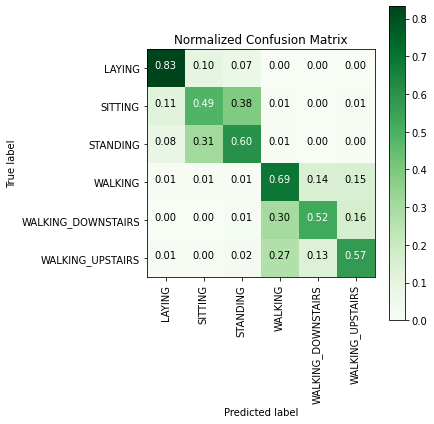

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.81      0.83      0.82       537
           SITTING       0.52      0.49      0.50       491
          STANDING       0.57      0.60      0.59       532
           WALKING       0.57      0.69      0.63       496
WALKING_DOWNSTAIRS       0.62      0.52      0.57       420
  WALKING_UPSTAIRS       0.65      0.57      0.61       471

          accuracy                           0.62      2947
         macro avg       0.62      0.62      0.62      2947
      weighted avg       0.62      0.62      0.62      2947



==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of vest estimator : 0.626498332847755
training the model...
Fitting

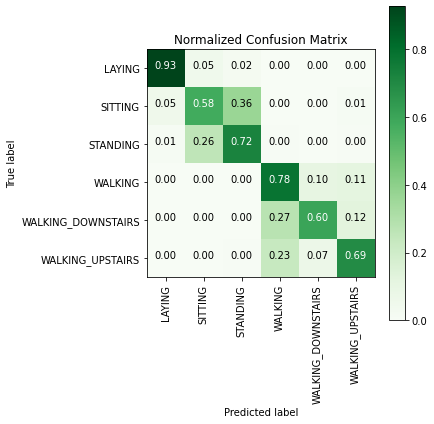

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.94      0.93      0.93       537
           SITTING       0.63      0.58      0.60       491
          STANDING       0.67      0.72      0.69       532
           WALKING       0.63      0.78      0.70       496
WALKING_DOWNSTAIRS       0.75      0.60      0.67       420
  WALKING_UPSTAIRS       0.74      0.69      0.72       471

          accuracy                           0.72      2947
         macro avg       0.73      0.72      0.72      2947
      weighted avg       0.73      0.72      0.72      2947



==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of vest estimator : 0.7196704541775922
training the model...
Fittin

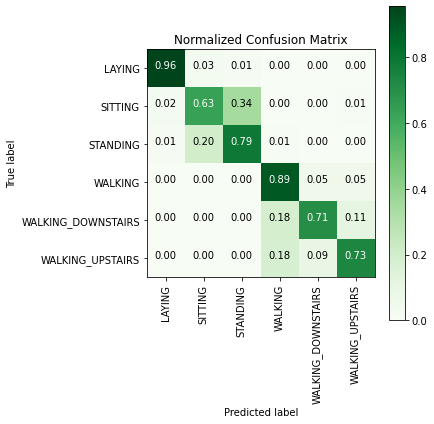

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.97      0.96      0.96       537
           SITTING       0.72      0.63      0.67       491
          STANDING       0.70      0.79      0.74       532
           WALKING       0.73      0.89      0.80       496
WALKING_DOWNSTAIRS       0.82      0.71      0.76       420
  WALKING_UPSTAIRS       0.82      0.73      0.77       471

          accuracy                           0.79      2947
         macro avg       0.79      0.78      0.79      2947
      weighted avg       0.79      0.79      0.79      2947



==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of vest estimator : 0.7860491035299232
training the model...
Fittin

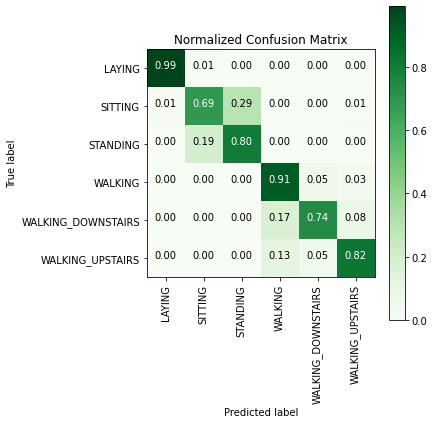

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.99      0.99      0.99       537
           SITTING       0.76      0.69      0.72       491
          STANDING       0.75      0.80      0.78       532
           WALKING       0.77      0.91      0.84       496
WALKING_DOWNSTAIRS       0.86      0.74      0.80       420
  WALKING_UPSTAIRS       0.88      0.82      0.85       471

          accuracy                           0.83      2947
         macro avg       0.83      0.83      0.83      2947
      weighted avg       0.83      0.83      0.83      2947



==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of vest estimator : 0.829167441279707
training the model...
Fitting

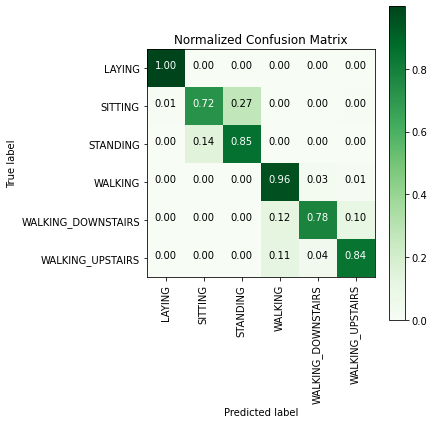

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.82      0.72      0.77       491
          STANDING       0.77      0.85      0.81       532
           WALKING       0.81      0.96      0.88       496
WALKING_DOWNSTAIRS       0.90      0.78      0.83       420
  WALKING_UPSTAIRS       0.88      0.84      0.86       471

          accuracy                           0.86      2947
         macro avg       0.86      0.86      0.86      2947
      weighted avg       0.86      0.86      0.86      2947



==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of vest estimator : 0.8427687213566596
training the model...
Fittin

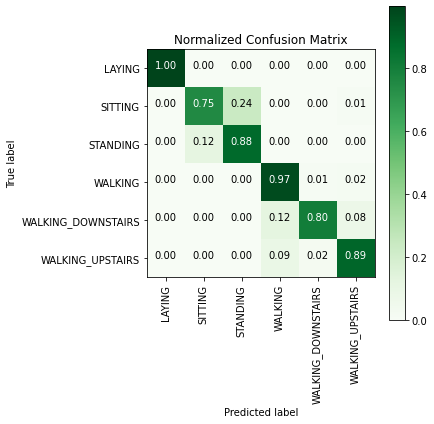

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.85      0.75      0.80       491
          STANDING       0.80      0.88      0.84       532
           WALKING       0.84      0.97      0.90       496
WALKING_DOWNSTAIRS       0.95      0.80      0.87       420
  WALKING_UPSTAIRS       0.90      0.89      0.90       471

          accuracy                           0.88      2947
         macro avg       0.89      0.88      0.88      2947
      weighted avg       0.89      0.88      0.88      2947



==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of vest estimator : 0.8716066168139587
training the model...
Fittin

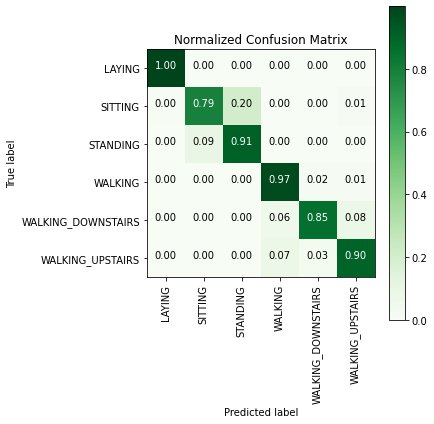

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.89      0.79      0.83       491
          STANDING       0.83      0.91      0.87       532
           WALKING       0.89      0.97      0.93       496
WALKING_DOWNSTAIRS       0.94      0.85      0.90       420
  WALKING_UPSTAIRS       0.91      0.90      0.90       471

          accuracy                           0.91      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.91      0.91      0.91      2947



==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of vest estimator : 0.8914637180501025


In [60]:
# precision = 0.1  # precision: 精度
# limit_x = 5
# linspace: num (個)の等差数列を作成
# epsilons = np.linspace(1, 5, num=int(limit_x/precision))
epsilons = [0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]


for epsilon in epsilons:
    # epsilon = 0.1
    # default sensitivity = 1.0

    X_train_noise = X_train.copy()
    X_test_noise = X_test.copy()

    X_train_noise_array = X_train_noise.values
    X_test_noise_array = X_test_noise.values

    for i in range(len(X_train_noise_array)):
        X_train_noise_array[i] = X_train_noise_array[i] + np.random.laplace(0, 1.0/epsilon, X_train_noise_array[i].shape)
    for j in range(len(X_test_noise_array)):
        X_test_noise_array[j] = X_test_noise_array[j] + np.random.laplace(0, 1.0/epsilon, X_test_noise_array[j].shape)


    # start Grid search
    # C: 正則化項の係数（正則化の強さの逆数）
    # penalty: 正則化をL1ノルムでやるかL2ノルムでやるかを，l1 または l2 から選択
    param_grid = [{
        'C': [0.01, 0.1, 1, 10, 20, 30],
        'penalty': ['l2', 'l1']
    }]
    log_reg = linear_model.LogisticRegression(random_state=0)
    log_reg_grid = GridSearchCV(log_reg, param_grid=param_grid, cv=5, verbose=1, n_jobs=1)
    print("As epsilon = {}".format(epsilon))
    log_reg_grid_results = perform_model(log_reg_grid, X_train_noise_array, y_train, X_test_noise_array, y_test, class_labels=labels)

    # observe the attributes of the model
    print_grid_search_attributes(log_reg_grid_results['model'])

## 2. Linear SVC with GridSearch

training the model...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

Done
==> training time:- 0:01:02.060332

Predicting test data
==> testing time:- 0:00:00.133043

==> Accuracy:- 0.9674244994910078


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  2 433  53   0   0   3]
 [  0  12 519   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   3 412   5]
 [  0   0   0  17   0 454]]


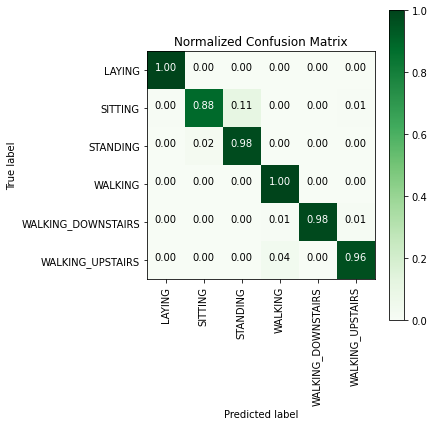

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.88      0.93       491
          STANDING       0.91      0.98      0.94       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



==> Best Estimator:
	LinearSVC(C=0.5, random_state=0, tol=5e-05)


==> Best parameters:
	Parameters of best estimator : {'C': 0.5}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of vest estimator : 0.9416565157674217


In [63]:
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
# tol: 停止基準の許容範囲
lr_svc = LinearSVC(tol=0.00005, random_state=0)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(lr_svc_grid_results['model'])

In [66]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

epsilons = [1, 1.5, 2, 2.5, 3, 4, 5]


for epsilon in epsilons:
    # epsilon = 0.1
    # default sensitivity = 1.0
    
    print("As epsilon = {}".format(epsilon))

    X_train_noise = X_train.copy()
    X_test_noise = X_test.copy()

    X_train_noise_array = X_train_noise.values
    X_test_noise_array = X_test_noise.values

    for i in range(len(X_train_noise_array)):
        X_train_noise_array[i] = X_train_noise_array[i] + np.random.laplace(0, 1.0/epsilon, X_train_noise_array[i].shape)
    for j in range(len(X_test_noise_array)):
        X_test_noise_array[j] = X_test_noise_array[j] + np.random.laplace(0, 1.0/epsilon, X_test_noise_array[j].shape)


    parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
    # tol: 停止基準の許容範囲
    lr_svc = LinearSVC(tol=0.00005, random_state=0)
    lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
    lr_svc_grid_results = perform_model(lr_svc_grid, X_train_noise_array, y_train, X_test_noise_array, y_test, class_labels=labels)

    # observe the attributes of the model 
    print_grid_search_attributes(lr_svc_grid_results['model'])

As epsilon = 1
training the model...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

KeyboardInterrupt: 

## 3. Kernel SVM with GridSearch
ガウスカーネル
𝐾(𝑥𝑖,𝑥𝑗)=exp(−𝛾||𝑥𝑖–𝑥𝑗||2)

training the model...
Done
==> training time:- 0:04:09.598501

Predicting test data
==> testing time:- 0:00:02.223328

==> Accuracy:- 0.9626739056667798


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 441  48   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 489   2   5]
 [  0   0   0   4 397  19]
 [  0   0   0  17   1 453]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_58509/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


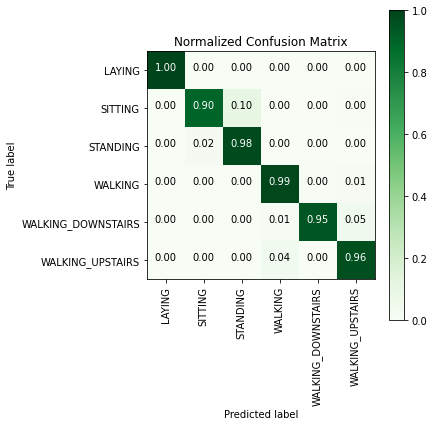

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



==> Best Estimator:
	SVC(C=16, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 16, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9447834551903698


In [13]:
# gamma: カーネル係数
# kernel: アルゴリズムで使用されるカーネルタイプを指定
parameters = {'C':[2,8,16],\
              'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=-1)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(rbf_svm_grid_results['model'])

As epsilon = 1.5
training the model...
Done
==> training time:- 0:09:22.638844

Predicting test data
==> testing time:- 0:00:09.558187

==> Accuracy:- 0.5286732270105192


 ********Confusion Matrix********

 [[531   0   6   0   0   0]
 [ 95  25 371   0   0   0]
 [ 31   4 497   0   0   0]
 [  0   0   2 494   0   0]
 [  1   0   1 415   3   0]
 [  4   0   9 450   0   8]]


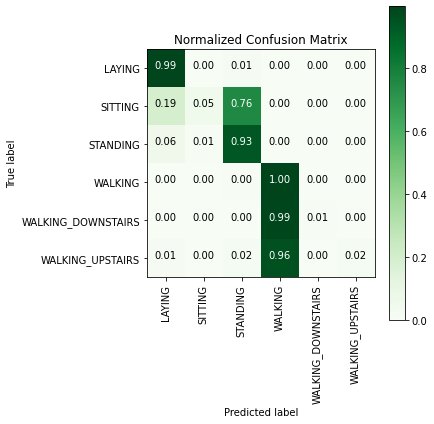

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.80      0.99      0.89       537
           SITTING       0.86      0.05      0.10       491
          STANDING       0.56      0.93      0.70       532
           WALKING       0.36      1.00      0.53       496
WALKING_DOWNSTAIRS       1.00      0.01      0.01       420
  WALKING_UPSTAIRS       1.00      0.02      0.03       471

          accuracy                           0.53      2947
         macro avg       0.76      0.50      0.38      2947
      weighted avg       0.75      0.53      0.40      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5331883072739634
As epsilon = 2
training the model...
Done
==>

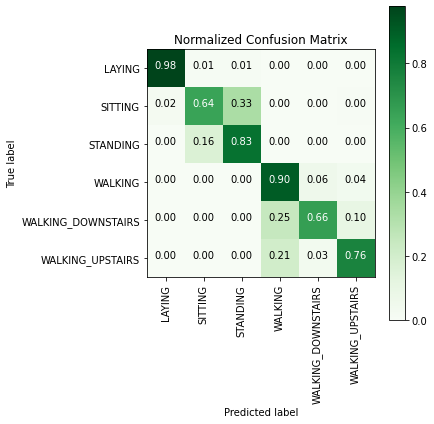

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.98      0.98      0.98       537
           SITTING       0.77      0.64      0.70       491
          STANDING       0.72      0.83      0.77       532
           WALKING       0.69      0.90      0.78       496
WALKING_DOWNSTAIRS       0.86      0.66      0.74       420
  WALKING_UPSTAIRS       0.85      0.76      0.80       471

          accuracy                           0.80      2947
         macro avg       0.81      0.79      0.80      2947
      weighted avg       0.81      0.80      0.80      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.802505121695177
As epsilon = 2.5
training the model...
Done
==

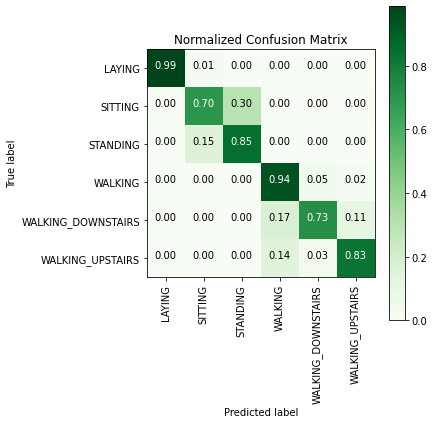

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99       537
           SITTING       0.80      0.70      0.75       491
          STANDING       0.76      0.85      0.80       532
           WALKING       0.77      0.94      0.85       496
WALKING_DOWNSTAIRS       0.89      0.73      0.80       420
  WALKING_UPSTAIRS       0.87      0.83      0.85       471

          accuracy                           0.84      2947
         macro avg       0.85      0.84      0.84      2947
      weighted avg       0.85      0.84      0.84      2947



==> Best Estimator:
	SVC(C=8, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 8, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8318851075440374
As epsilon = 3
training the model...
Done
==>

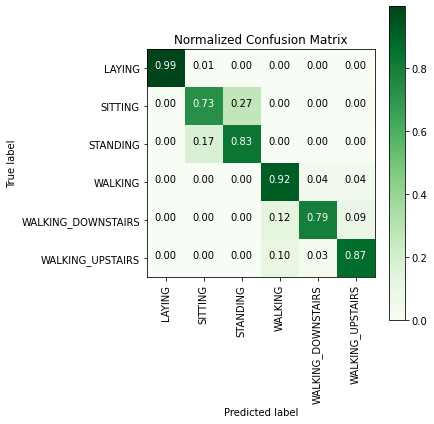

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       537
           SITTING       0.79      0.73      0.76       491
          STANDING       0.77      0.83      0.80       532
           WALKING       0.82      0.92      0.87       496
WALKING_DOWNSTAIRS       0.91      0.79      0.85       420
  WALKING_UPSTAIRS       0.88      0.87      0.87       471

          accuracy                           0.86      2947
         macro avg       0.86      0.85      0.86      2947
      weighted avg       0.86      0.86      0.86      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.858410262813487
As epsilon = 4
training the model...
Done
==> 

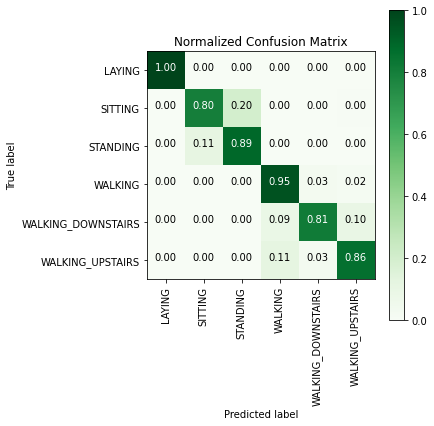

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.87      0.80      0.83       491
          STANDING       0.83      0.89      0.86       532
           WALKING       0.84      0.95      0.89       496
WALKING_DOWNSTAIRS       0.92      0.81      0.87       420
  WALKING_UPSTAIRS       0.89      0.86      0.87       471

          accuracy                           0.89      2947
         macro avg       0.89      0.89      0.89      2947
      weighted avg       0.89      0.89      0.89      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8705167015820605
As epsilon = 5
training the model...
Done
==>

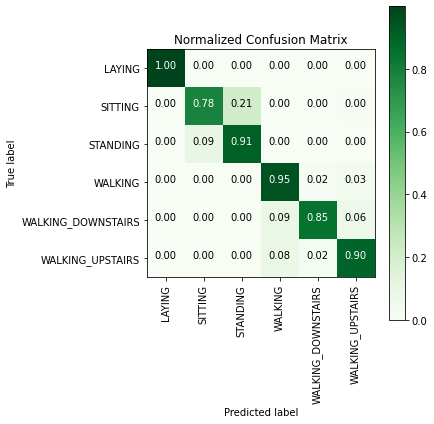

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.88      0.78      0.83       491
          STANDING       0.82      0.91      0.86       532
           WALKING       0.86      0.95      0.90       496
WALKING_DOWNSTAIRS       0.95      0.85      0.90       420
  WALKING_UPSTAIRS       0.90      0.90      0.90       471

          accuracy                           0.90      2947
         macro avg       0.90      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8936406812895111


In [14]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

epsilons = [1.5, 2, 2.5, 3, 4, 5]


for epsilon in epsilons:
    # epsilon = 0.1
    # default sensitivity = 1.0
    
    print("As epsilon = {}".format(epsilon))

    X_train_noise = X_train.copy()
    X_test_noise = X_test.copy()

    X_train_noise_array = X_train_noise.values
    X_test_noise_array = X_test_noise.values

    for i in range(len(X_train_noise_array)):
        X_train_noise_array[i] = X_train_noise_array[i] + np.random.laplace(0, 1.0/epsilon, X_train_noise_array[i].shape)
    for j in range(len(X_test_noise_array)):
        X_test_noise_array[j] = X_test_noise_array[j] + np.random.laplace(0, 1.0/epsilon, X_test_noise_array[j].shape)
        
    
    # gamma: カーネル係数
    # kernel: ルゴリズムで使用されるカーネルタイプを指定
    parameters = {'C':[2,8,16],\
                'gamma': [ 0.0078125, 0.125, 2]}
    # カーネル関数： rbf = ガウスカーネル
    rbf_svm = SVC(kernel='rbf')
    rbf_svm_grid = GridSearchCV(rbf_svm, param_grid=parameters, n_jobs=-1)
    rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train_noise_array, y_train, X_test_noise_array, y_test, class_labels=labels)

    # observe the attributes of the model 
    print_grid_search_attributes(rbf_svm_grid_results['model'])


## 4. LightGBM with GridSearchCV

## 5. Random Forest Classifier with GridSearch

training the model...
Done
==> training time:- 0:11:51.450810

Predicting test data
==> testing time:- 0:00:00.623228

==> Accuracy:- 0.9300984051577876


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 440  51   0   0   0]
 [  0  42 490   0   0   0]
 [  0   0   0 484   8   4]
 [  0   0   0  17 359  44]
 [  0   0   0  33   7 431]]


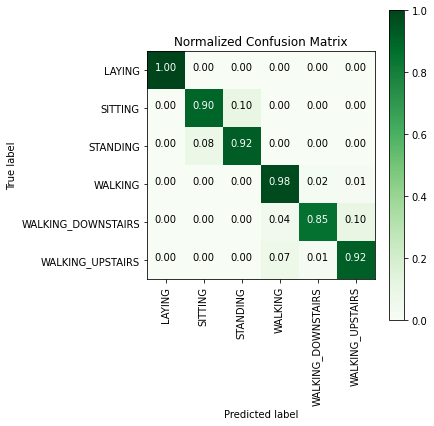

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.90      0.90       491
          STANDING       0.91      0.92      0.91       532
           WALKING       0.91      0.98      0.94       496
WALKING_DOWNSTAIRS       0.96      0.85      0.90       420
  WALKING_UPSTAIRS       0.90      0.92      0.91       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=50)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 50}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9223388226806698


In [88]:
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(rfc_grid_results['model'])

As epsilon = 0.1
training the model...
Done
==> training time:- 0:07:41.404062

Predicting test data
==> testing time:- 0:00:00.118275

==> Accuracy:- 0.2042755344418052


 ********Confusion Matrix********

 [[267  55 179  35   0   1]
 [222  81 157  30   0   1]
 [233  67 203  28   0   1]
 [224  54 165  50   0   3]
 [179  72 137  26   0   6]
 [236  55 150  28   1   1]]


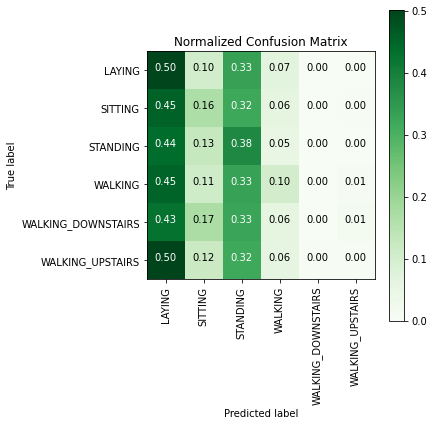

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.20      0.50      0.28       537
           SITTING       0.21      0.16      0.19       491
          STANDING       0.20      0.38      0.27       532
           WALKING       0.25      0.10      0.14       496
WALKING_DOWNSTAIRS       0.00      0.00      0.00       420
  WALKING_UPSTAIRS       0.08      0.00      0.00       471

          accuracy                           0.20      2947
         macro avg       0.16      0.19      0.15      2947
      weighted avg       0.16      0.20      0.16      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=9, n_estimators=110)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 9, 'n_estimators': 110}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.20089633134014995
As epsi

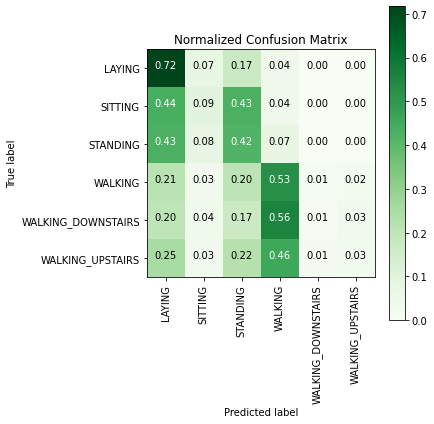

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.34      0.72      0.46       537
           SITTING       0.27      0.09      0.14       491
          STANDING       0.28      0.42      0.33       532
           WALKING       0.33      0.53      0.41       496
WALKING_DOWNSTAIRS       0.22      0.01      0.02       420
  WALKING_UPSTAIRS       0.35      0.03      0.05       471

          accuracy                           0.32      2947
         macro avg       0.30      0.30      0.23      2947
      weighted avg       0.30      0.32      0.25      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=7, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 7, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.3303879539579258
As epsil

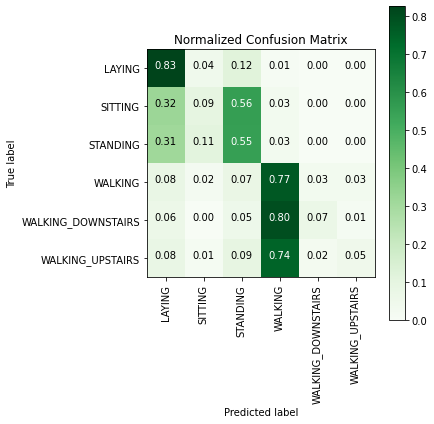

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.51      0.83      0.63       537
           SITTING       0.32      0.09      0.14       491
          STANDING       0.40      0.55      0.46       532
           WALKING       0.35      0.77      0.48       496
WALKING_DOWNSTAIRS       0.55      0.07      0.12       420
  WALKING_UPSTAIRS       0.54      0.05      0.09       471

          accuracy                           0.41      2947
         macro avg       0.44      0.39      0.32      2947
      weighted avg       0.44      0.41      0.33      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=7, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 7, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.4243758468717195
As epsil

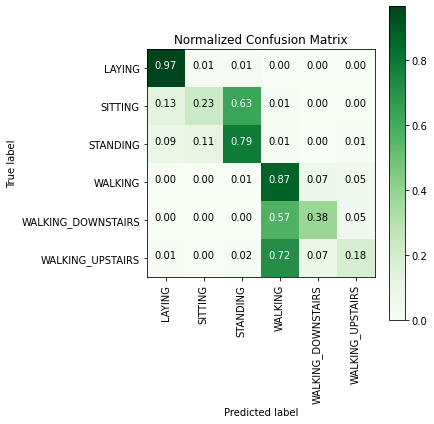

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.82      0.97      0.89       537
           SITTING       0.63      0.23      0.33       491
          STANDING       0.56      0.79      0.66       532
           WALKING       0.42      0.87      0.57       496
WALKING_DOWNSTAIRS       0.70      0.38      0.49       420
  WALKING_UPSTAIRS       0.61      0.18      0.28       471

          accuracy                           0.59      2947
         macro avg       0.62      0.57      0.54      2947
      weighted avg       0.62      0.59      0.55      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=9, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 9, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6123489504571373
As epsil

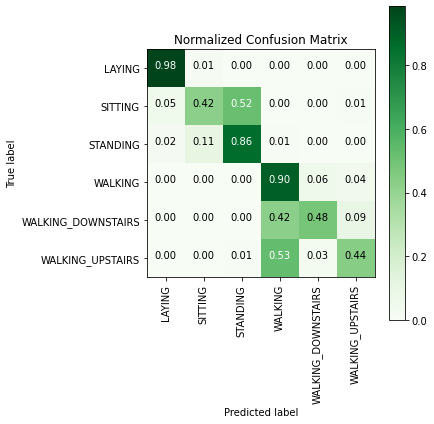

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.93      0.98      0.96       537
           SITTING       0.76      0.42      0.54       491
          STANDING       0.64      0.86      0.73       532
           WALKING       0.51      0.90      0.65       496
WALKING_DOWNSTAIRS       0.82      0.48      0.61       420
  WALKING_UPSTAIRS       0.76      0.44      0.55       471

          accuracy                           0.69      2947
         macro avg       0.74      0.68      0.67      2947
      weighted avg       0.74      0.69      0.68      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=9, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 9, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.718850335511499
As epsilo

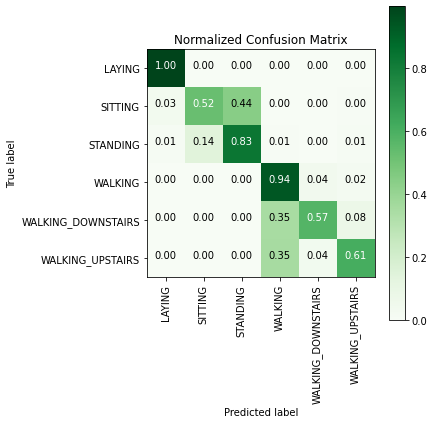

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.96      1.00      0.98       537
           SITTING       0.77      0.52      0.62       491
          STANDING       0.67      0.83      0.74       532
           WALKING       0.59      0.94      0.73       496
WALKING_DOWNSTAIRS       0.86      0.57      0.69       420
  WALKING_UPSTAIRS       0.85      0.61      0.71       471

          accuracy                           0.76      2947
         macro avg       0.78      0.74      0.74      2947
      weighted avg       0.78      0.76      0.75      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=11, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 11, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7833241304679588
As eps

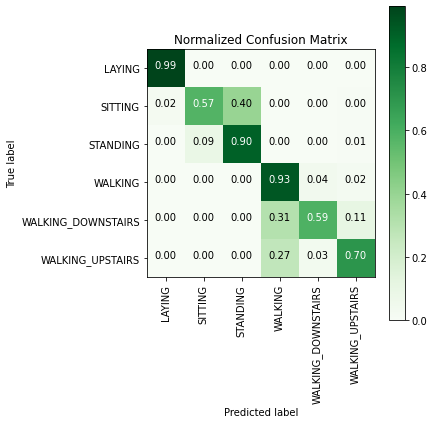

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.98      0.99      0.99       537
           SITTING       0.85      0.57      0.69       491
          STANDING       0.71      0.90      0.79       532
           WALKING       0.64      0.93      0.76       496
WALKING_DOWNSTAIRS       0.87      0.59      0.70       420
  WALKING_UPSTAIRS       0.84      0.70      0.76       471

          accuracy                           0.79      2947
         macro avg       0.82      0.78      0.78      2947
      weighted avg       0.82      0.79      0.79      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=9, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 9, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8135222001785077
As epsil

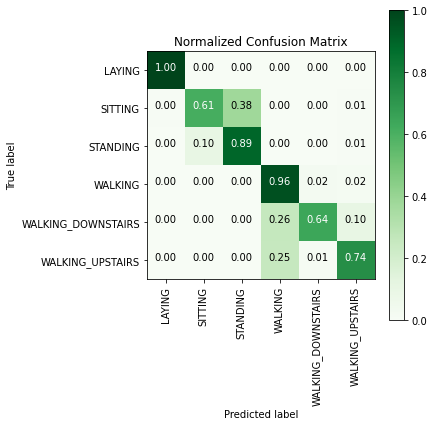

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.85      0.61      0.71       491
          STANDING       0.72      0.89      0.80       532
           WALKING       0.68      0.96      0.79       496
WALKING_DOWNSTAIRS       0.94      0.64      0.76       420
  WALKING_UPSTAIRS       0.86      0.74      0.79       471

          accuracy                           0.82      2947
         macro avg       0.84      0.81      0.81      2947
      weighted avg       0.84      0.82      0.81      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8416773262670126
As eps

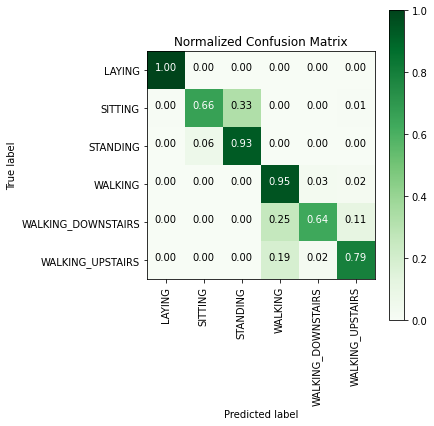

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.66      0.76       491
          STANDING       0.75      0.93      0.83       532
           WALKING       0.70      0.95      0.81       496
WALKING_DOWNSTAIRS       0.91      0.64      0.75       420
  WALKING_UPSTAIRS       0.86      0.79      0.82       471

          accuracy                           0.84      2947
         macro avg       0.85      0.83      0.83      2947
      weighted avg       0.85      0.84      0.83      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=11, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 11, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8646662689548966
As eps

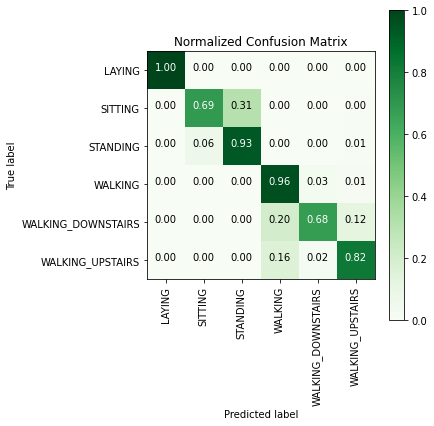

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.69      0.78       491
          STANDING       0.77      0.93      0.84       532
           WALKING       0.75      0.96      0.84       496
WALKING_DOWNSTAIRS       0.92      0.68      0.78       420
  WALKING_UPSTAIRS       0.87      0.82      0.84       471

          accuracy                           0.86      2947
         macro avg       0.87      0.85      0.85      2947
      weighted avg       0.87      0.86      0.85      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=11, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 11, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.878810471843394


In [87]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

epsilons = [0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]


for epsilon in epsilons:
    # epsilon = 0.1
    # default sensitivity = 1.0
    
    print("As epsilon = {}".format(epsilon))

    X_train_noise = X_train.copy()
    X_test_noise = X_test.copy()

    X_train_noise_array = X_train_noise.values
    X_test_noise_array = X_test_noise.values

    for i in range(len(X_train_noise_array)):
        X_train_noise_array[i] = X_train_noise_array[i] + np.random.laplace(0, 1.0/epsilon, X_train_noise_array[i].shape)
    for j in range(len(X_test_noise_array)):
        X_test_noise_array[j] = X_test_noise_array[j] + np.random.laplace(0, 1.0/epsilon, X_test_noise_array[j].shape)
    
    params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
    rfc = RandomForestClassifier()
    rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)
    rfc_grid_results = perform_model(rfc_grid, X_train_noise_array, y_train, X_test_noise_array, y_test, class_labels=labels)

    # observe the attributes of the model 
    print_grid_search_attributes(rfc_grid_results['model'])


## 6. Gradient Boosted Decision Trees With GridSearch

## 7. PATE
[参考URL](https://github.com/gmodena/tinydp)

sensitivity : 1.0 固定


As epsilon = 0.01
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:13.155251

Predicting test data
==> testing time:- 0:00:00.343610

==> Accuracy:- 0.3203257550050899


 ********Confusion Matrix********

 [[252 274  11   0   0   0]
 [193 210  83   2   2   1]
 [163 174 193   2   0   0]
 [121  93 115 136  25   6]
 [ 94  88  68  83  66  21]
 [ 84  71  67  80  82  87]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


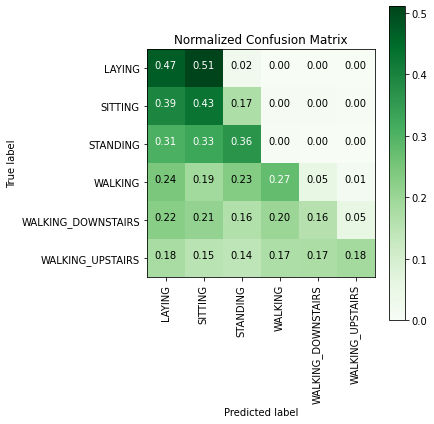

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.28      0.47      0.35       537
           SITTING       0.23      0.43      0.30       491
          STANDING       0.36      0.36      0.36       532
           WALKING       0.45      0.27      0.34       496
WALKING_DOWNSTAIRS       0.38      0.16      0.22       420
  WALKING_UPSTAIRS       0.76      0.18      0.30       471

          accuracy                           0.32      2947
         macro avg       0.41      0.31      0.31      2947
      weighted avg       0.40      0.32      0.32      2947

As epsilon = 0.05
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:27.722976

Predicting test data
==> testing time:- 0:00:00.214875

==> Accuracy:- 0.38411944350186633


 ********Confusion Matrix********

 [[300 224  13   0   0   0]
 [170 233  83   2   2   1]
 [146 157 227   2   0   0]
 [108  78 104 175  25   6]
 [ 85  81  63  81  87  23]
 [ 79  66  59  77  80 110]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


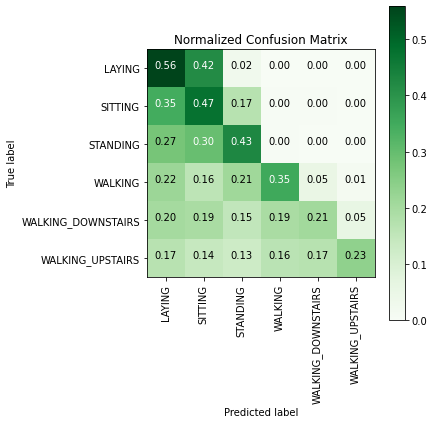

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.34      0.56      0.42       537
           SITTING       0.28      0.47      0.35       491
          STANDING       0.41      0.43      0.42       532
           WALKING       0.52      0.35      0.42       496
WALKING_DOWNSTAIRS       0.45      0.21      0.28       420
  WALKING_UPSTAIRS       0.79      0.23      0.36       471

          accuracy                           0.38      2947
         macro avg       0.46      0.38      0.38      2947
      weighted avg       0.46      0.38      0.38      2947

As epsilon = 0.1
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:09.294547

Predicting test data
==> testing time:- 0:00:00.246867

==> Accuracy:- 0.4648795385137428


 ********Confusion Matrix********

 [[362 162  13   0   0   0]
 [136 270  80   2   2   1]
 [129 138 264   1   0   0]
 [ 96  66  91 213  24   6]
 [ 80  74  51  72 117  26]
 [ 73  59  52  71  72 144]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


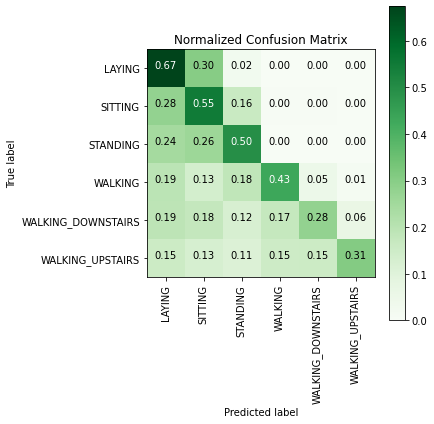

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.41      0.67      0.51       537
           SITTING       0.35      0.55      0.43       491
          STANDING       0.48      0.50      0.49       532
           WALKING       0.59      0.43      0.50       496
WALKING_DOWNSTAIRS       0.54      0.28      0.37       420
  WALKING_UPSTAIRS       0.81      0.31      0.44       471

          accuracy                           0.46      2947
         macro avg       0.53      0.46      0.46      2947
      weighted avg       0.53      0.46      0.46      2947

As epsilon = 0.3
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:06.826833

Predicting test data
==> testing time:- 0:00:00.225511

==> Accuracy:- 0.7112317611129962


 ********Confusion Matrix********

 [[475  48  14   0   0   0]
 [ 57 357  73   1   1   2]
 [ 56  84 391   1   0   0]
 [ 43  31  45 352  20   5]
 [ 40  37  22  51 242  28]
 [ 36  27  30  50  49 279]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


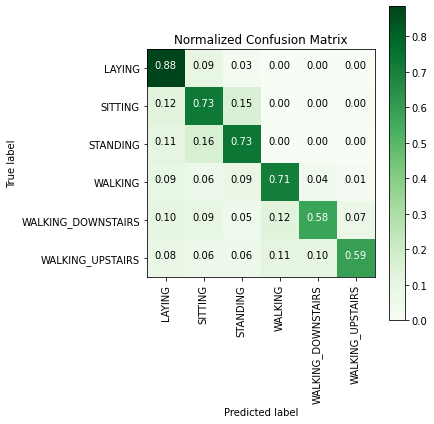

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.67      0.88      0.76       537
           SITTING       0.61      0.73      0.66       491
          STANDING       0.68      0.73      0.71       532
           WALKING       0.77      0.71      0.74       496
WALKING_DOWNSTAIRS       0.78      0.58      0.66       420
  WALKING_UPSTAIRS       0.89      0.59      0.71       471

          accuracy                           0.71      2947
         macro avg       0.73      0.70      0.71      2947
      weighted avg       0.73      0.71      0.71      2947

As epsilon = 0.5
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:26.514238

Predicting test data
==> testing time:- 0:00:00.251138

==> Accuracy:- 0.837461825585341


 ********Confusion Matrix********

 [[500  23  14   0   0   0]
 [ 24 405  59   0   0   3]
 [ 20  67 444   1   0   0]
 [ 14  16  10 438  17   1]
 [ 18  16  10  42 305  29]
 [ 15   6  14  31  29 376]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


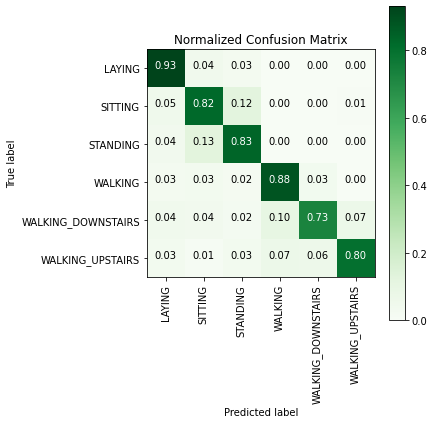

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.85      0.93      0.89       537
           SITTING       0.76      0.82      0.79       491
          STANDING       0.81      0.83      0.82       532
           WALKING       0.86      0.88      0.87       496
WALKING_DOWNSTAIRS       0.87      0.73      0.79       420
  WALKING_UPSTAIRS       0.92      0.80      0.85       471

          accuracy                           0.84      2947
         macro avg       0.84      0.83      0.84      2947
      weighted avg       0.84      0.84      0.84      2947

As epsilon = 1.0
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:20.333458

Predicting test data
==> testing time:- 0:00:00.357816

==> Accuracy:- 0.9189005768578216


 ********Confusion Matrix********

 [[523   2  12   0   0   0]
 [  2 432  54   0   0   3]
 [  2  45 485   0   0   0]
 [  1   1   0 477  17   0]
 [  0   2   3  32 360  23]
 [  2   2   2  20  14 431]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


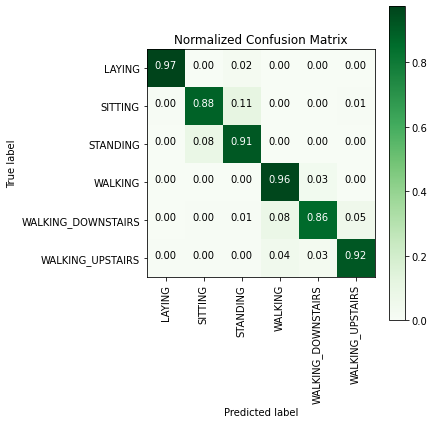

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.99      0.97      0.98       537
           SITTING       0.89      0.88      0.89       491
          STANDING       0.87      0.91      0.89       532
           WALKING       0.90      0.96      0.93       496
WALKING_DOWNSTAIRS       0.92      0.86      0.89       420
  WALKING_UPSTAIRS       0.94      0.92      0.93       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947

As epsilon = 1.5
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:10.019931

Predicting test data
==> testing time:- 0:00:00.198463

==> Accuracy:- 0.9290804207668816


 ********Confusion Matrix********

 [[524   0  13   0   0   0]
 [  1 438  49   0   0   3]
 [  0  43 489   0   0   0]
 [  0   0   0 480  16   0]
 [  0   1   1  31 365  22]
 [  0   0   0  20   9 442]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


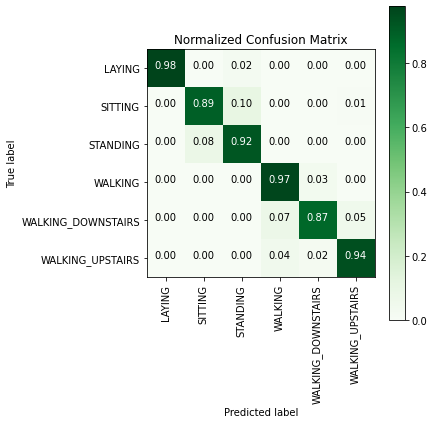

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.91      0.89      0.90       491
          STANDING       0.89      0.92      0.90       532
           WALKING       0.90      0.97      0.93       496
WALKING_DOWNSTAIRS       0.94      0.87      0.90       420
  WALKING_UPSTAIRS       0.95      0.94      0.94       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947

As epsilon = 2.0
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:13.918328

Predicting test data
==> testing time:- 0:00:00.312612

==> Accuracy:- 0.9328130302002036


 ********Confusion Matrix********

 [[525   0  12   0   0   0]
 [  0 441  47   0   0   3]
 [  0  41 491   0   0   0]
 [  0   0   0 480  16   0]
 [  0   1   0  29 367  23]
 [  0   0   0  18   8 445]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


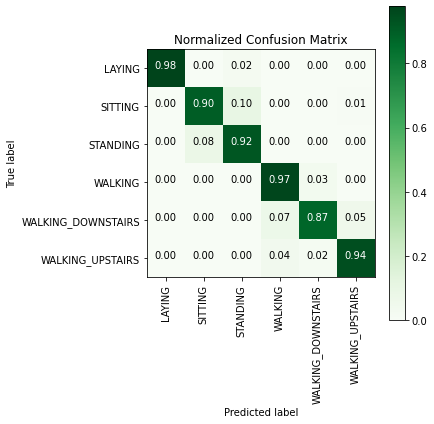

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.91      0.90      0.91       491
          STANDING       0.89      0.92      0.91       532
           WALKING       0.91      0.97      0.94       496
WALKING_DOWNSTAIRS       0.94      0.87      0.91       420
  WALKING_UPSTAIRS       0.94      0.94      0.94       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947

As epsilon = 2.5
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:24.094210

Predicting test data
==> testing time:- 0:00:00.270205

==> Accuracy:- 0.9338310145911096


 ********Confusion Matrix********

 [[525   0  12   0   0   0]
 [  0 441  47   0   0   3]
 [  0  42 490   0   0   0]
 [  0   0   0 480  16   0]
 [  0   1   0  26 370  23]
 [  0   0   0  18   7 446]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


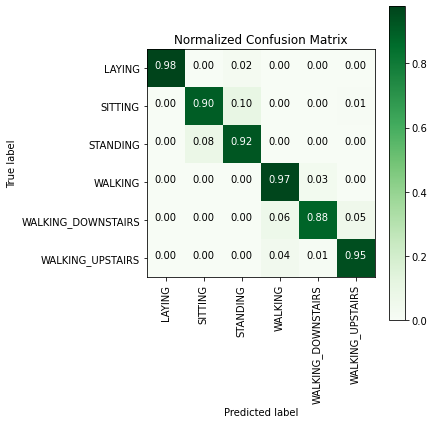

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.91      0.90      0.90       491
          STANDING       0.89      0.92      0.91       532
           WALKING       0.92      0.97      0.94       496
WALKING_DOWNSTAIRS       0.94      0.88      0.91       420
  WALKING_UPSTAIRS       0.94      0.95      0.95       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947

As epsilon = 3
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:10.281479

Predicting test data
==> testing time:- 0:00:00.254324

==> Accuracy:- 0.9331523583305056


 ********Confusion Matrix********

 [[525   0  12   0   0   0]
 [  0 442  46   0   0   3]
 [  0  44 488   0   0   0]
 [  0   0   0 480  16   0]
 [  0   1   0  26 369  24]
 [  0   0   0  18   7 446]]


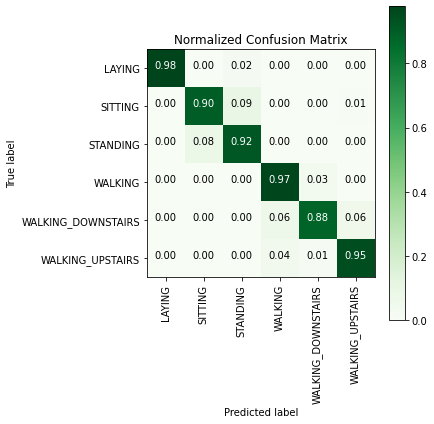

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.91      0.90      0.90       491
          STANDING       0.89      0.92      0.91       532
           WALKING       0.92      0.97      0.94       496
WALKING_DOWNSTAIRS       0.94      0.88      0.91       420
  WALKING_UPSTAIRS       0.94      0.95      0.94       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947

As epsilon = 4
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:13.603767

Predicting test data
==> testing time:- 0:00:00.273268

==> Accuracy:- 0.9341703427214116


 ********Confusion Matrix********

 [[525   0  12   0   0   0]
 [  0 442  46   0   0   3]
 [  0  44 488   0   0   0]
 [  0   0   0 480  16   0]
 [  0   1   0  25 371  23]
 [  0   0   0  17   7 447]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


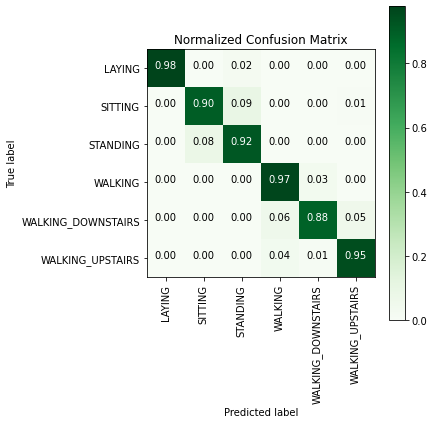

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.91      0.90      0.90       491
          STANDING       0.89      0.92      0.91       532
           WALKING       0.92      0.97      0.94       496
WALKING_DOWNSTAIRS       0.94      0.88      0.91       420
  WALKING_UPSTAIRS       0.95      0.95      0.95       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947

As epsilon = 5
training the model...


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:00:12.321001

Predicting test data
==> testing time:- 0:00:00.379192

==> Accuracy:- 0.9341703427214116


 ********Confusion Matrix********

 [[525   0  12   0   0   0]
 [  0 442  46   0   0   3]
 [  0  44 488   0   0   0]
 [  0   0   0 480  16   0]
 [  0   1   0  25 371  23]
 [  0   0   0  17   7 447]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_6586/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


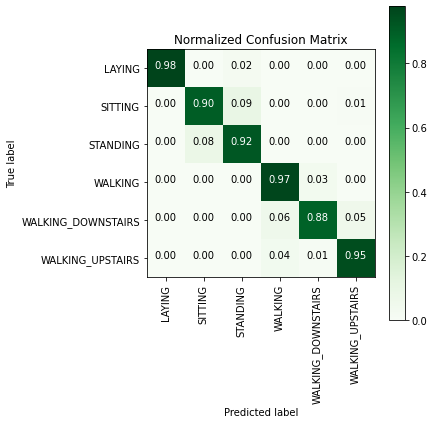

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.91      0.90      0.90       491
          STANDING       0.89      0.92      0.91       532
           WALKING       0.92      0.97      0.94       496
WALKING_DOWNSTAIRS       0.94      0.88      0.91       420
  WALKING_UPSTAIRS       0.95      0.95      0.95       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



In [10]:
from dp.ensemble import PrivateClassifier
from sklearn.metrics import classification_report

X_private = X_train.copy().values
y_private = y_train.copy().values
X_public = X_test.copy().values
y_public = y_test.copy().values

# parameters = {'epsilon': [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]}

epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]

for epsilon in epsilons:
    
    print("As epsilon = {}".format(epsilon))

    # n_estimators: 訓練データを割り切れる数
    private_clf = PrivateClassifier(n_estimators=8, epsilon=epsilon ,random_state=1)
    # private_clf_grid = GridSearchCV(private_clf, param_grid=parameters, n_jobs=-1)
    private_clf_results = perform_model(private_clf, X_private, y_private, X_public, y_public, class_labels=labels)

# observe the attributes of the model 
# print_grid_search_attributes(private_clf_grid_results['model'])


In [16]:
from syft.frameworks.torch.dp import pate

data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=private_clf.teacher_preds,
                                                   indices=y_public,
                                                   noise_eps=0.1, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

ModuleNotFoundError: No module named 'syft.frameworks'

## 8. Comparing all models